In [8]:
import pandas as pd
import numpy as np

## Read trips dataset and external data

In [11]:
# Trips data
df = pd.read_csv('E_Scooter_Trips.csv')

# Weather data
weather = pd.read_csv('Chicago_Weather.csv')

# Crime data
crime = pd.read_csv('Chicago_Crimes.csv')

# Gas data
gas_prices = pd.read_csv('Weekly_Gas_Prices_Abridged.csv')

print(f'Trips Dataset: {df.shape}\nWeather Data: {weather.shape}\nCrime Data: {crime.shape}\nGas Data: {gas_prices.shape}')

Trips Dataset: (3797237, 16)
Weather Data: (514, 33)
Crime Data: (8041530, 22)
Gas Data: (104, 2)


In [14]:
df.head()

,Trip ID,Start Time,End Time,Trip Distance,Trip Duration,Vendor,Start Community Area Number,End Community Area Number,Start Community Area Name,End Community Area Name,Start Centroid Latitude,Start Centroid Longitude,Start Centroid Location,End Centroid Latitude,End Centroid Longitude,End Centroid Location
0,17553846-c8d6-b9de-1755-3846c8d6b9de,05/28/2022 02:00:00 PM,05/28/2022 03:00:00 PM,2484,1544,Lyft,32.0,32.0,Loop,Loop,41.878866,-87.625192,POINT (-87.62519186960115 41.87886594636445),41.878866,-87.625192,POINT (-87.62519186960115 41.87886594636445)
1,1756d4dc-ccf1-af42-1756-d4dcccf1af42,05/29/2022 07:00:00 PM,05/29/2022 08:00:00 PM,36,135,Lyft,32.0,32.0,Loop,Loop,41.878866,-87.625192,POINT (-87.62519186960115 41.87886594636445),41.878866,-87.625192,POINT (-87.62519186960115 41.87886594636445)
2,1756d578-f376-9950-1756-d578f3769950,05/29/2022 08:00:00 PM,05/29/2022 08:00:00 PM,2653,1972,Lyft,32.0,NaN,Loop,NaN,41.878866,-87.625192,POINT (-87.62519186960115 41.87886594636445),NaN,NaN,NaN
3,1756fc61-f058-c200-1756-fc61f058c200,05/29/2022 10:00:00 PM,05/29/2022 10:00:00 PM,105,137,Lyft,32.0,NaN,Loop,NaN,41.878866,-87.625192,POINT (-87.62519186960115 41.87886594636445),NaN,NaN,NaN
4,17659074-0cfd-92ca-1765-90740cfd92ca,06/10/2022 12:00:00 AM,06/10/2022 12:00:00 AM,2299,540,Lyft,8.0,24.0,Near North Side,West Town,41.899602,-87.633309,POINT (-87.63330943703569 41.899602106426094),41.901207,-87.676357,POINT (-87.67635712603905 41.90120673431551)


In [15]:
weather.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"Chicago,United States",2022-05-05,52.9,44.3,49.7,52.9,40.5,48.8,42.7,76.8,...,3.5,1,10,2022-05-05T05:41:32,2022-05-05T19:53:38,0.16,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"72534014819,AP878,KORD,KMDW,72530094846,F1983,..."
1,"Chicago,United States",2022-05-06,52.7,49.7,51.1,52.7,45.1,50.9,45.2,81.4,...,2.1,1,10,2022-05-06T05:40:18,2022-05-06T19:54:43,0.19,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,rain,"72534014819,AP878,KORD,KMDW,72530094846,F1983,..."
2,"Chicago,United States",2022-05-07,64.5,47.6,55.9,64.5,43.9,55.5,31.4,40.6,...,19.0,9,10,2022-05-07T05:39:06,2022-05-07T19:55:47,0.22,Clear,Clear conditions throughout the day.,clear-day,"72534014819,KORD,KMDW,72530094846,F1983,744665..."
3,"Chicago,United States",2022-05-08,66.9,45.7,58.3,66.9,43.8,57.8,38.8,48.8,...,8.5,4,10,2022-05-08T05:37:55,2022-05-08T19:56:51,0.25,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72534014819,C8740,KORD,KMDW,72530094846,F1983,..."
4,"Chicago,United States",2022-05-09,83.5,57.1,70.8,83.3,57.1,70.8,50.8,49.6,...,13.9,7,10,2022-05-09T05:36:45,2022-05-09T19:57:54,0.29,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,F1983,744665..."


In [16]:
crime.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,5741943,HN549294,08/25/2007 09:22:18 AM,074XX N ROGERS AVE,0560,ASSAULT,SIMPLE,OTHER,False,False,...,49.0,1.0,08A,NaN,NaN,2007,08/17/2015 03:03:40 PM,NaN,NaN,NaN
1,25953,JE240540,05/24/2021 03:06:00 PM,020XX N LARAMIE AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,...,36.0,19.0,01A,1141387.0,1913179.0,2021,11/18/2023 03:39:49 PM,41.917838,-87.755969,"(41.917838056, -87.755968972)"
2,26038,JE279849,06/26/2021 09:24:00 AM,062XX N MC CORMICK RD,0110,HOMICIDE,FIRST DEGREE MURDER,PARKING LOT,True,False,...,50.0,13.0,01A,1152781.0,1941458.0,2021,11/18/2023 03:39:49 PM,41.995219,-87.713355,"(41.995219444, -87.713354912)"
3,13279676,JG507211,11/09/2023 07:30:00 AM,019XX W BYRON ST,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,False,...,47.0,5.0,05,1162518.0,1925906.0,2023,11/18/2023 03:39:49 PM,41.952345,-87.677975,"(41.952345086, -87.677975059)"
4,13274752,JG501049,11/12/2023 07:59:00 AM,086XX S COTTAGE GROVE AVE,0454,BATTERY,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...",SMALL RETAIL STORE,True,False,...,6.0,44.0,08B,1183071.0,1847869.0,2023,12/09/2023 03:41:24 PM,41.737751,-87.604856,"(41.737750767, -87.604855911)"


In [17]:
gas_prices.head()

,Date,"Weekly Chicago, IL Regular Reformulated Retail Gasoline Prices (Dollars per Gallon)"
0,5/2/2022,4.467
1,5/9/2022,4.672
2,5/16/2022,4.929
3,5/23/2022,5.133
4,5/30/2022,5.264


In [13]:
df[['Trip ID', 'Start Time', 'End Time', 'Trip Distance', 'Trip Duration', 'Vendor']].head()

,Trip ID,Start Time,End Time,Trip Distance,Trip Duration,Vendor
0,17553846-c8d6-b9de-1755-3846c8d6b9de,05/28/2022 02:00:00 PM,05/28/2022 03:00:00 PM,2484,1544,Lyft
1,1756d4dc-ccf1-af42-1756-d4dcccf1af42,05/29/2022 07:00:00 PM,05/29/2022 08:00:00 PM,36,135,Lyft
2,1756d578-f376-9950-1756-d578f3769950,05/29/2022 08:00:00 PM,05/29/2022 08:00:00 PM,2653,1972,Lyft
3,1756fc61-f058-c200-1756-fc61f058c200,05/29/2022 10:00:00 PM,05/29/2022 10:00:00 PM,105,137,Lyft
4,17659074-0cfd-92ca-1765-90740cfd92ca,06/10/2022 12:00:00 AM,06/10/2022 12:00:00 AM,2299,540,Lyft


In [18]:
crime['Community Area'].value_counts()

25.0    460676
8.0     263683
43.0    244859
23.0    230977
28.0    227227
         ...  
74.0     16620
12.0     13853
47.0     11070
9.0       7431
0.0         76
Name: Community Area, Length: 78, dtype: int64

### Remove empty rows/missing data

In [37]:
entries_with_missing = df.isnull().any(axis=1).sum()
print(f"Entries with at least one missing value: {entries_with_missing}")

Entries with at least one missing value: 0


In [38]:
# Example for checking missing in both start and end centroid locations
missing_all_specified = df[['Start Centroid Location', 'End Centroid Location']].isnull().all(axis=1).sum()
print(f"Entries missing all values in specified columns: {missing_all_specified}")

Entries missing all values in specified columns: 0


In [39]:
complete_entries = df.dropna().shape[0]
print(f"Complete entries with no missing values: {complete_entries}")

Complete entries with no missing values: 3790619


In [40]:
missing_start_or_end_area = df[df['Start Community Area Number'].isnull() | df['End Community Area Number'].isnull()].shape[0]
print(f"Trips missing either start or end community area information: {missing_start_or_end_area}")

Trips missing either start or end community area information: 0


In [41]:
unique_trip_ids = df['Trip ID'].nunique()
print(f"Number of unique Trip IDs: {unique_trip_ids}")

Number of unique Trip IDs: 3790619


In [20]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)

Trip ID                           0
Start Time                        0
End Time                          0
Trip Distance                     0
Trip Duration                     0
Vendor                            0
Start Community Area Number    2827
End Community Area Number      3941
Start Community Area Name      2827
End Community Area Name        3941
Start Centroid Latitude        2827
Start Centroid Longitude       2827
Start Centroid Location        2827
End Centroid Latitude          3941
End Centroid Longitude         3941
End Centroid Location          3941
dtype: int64


In [21]:
df = df.dropna()

In [22]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)

Trip ID                        0
Start Time                     0
End Time                       0
Trip Distance                  0
Trip Duration                  0
Vendor                         0
Start Community Area Number    0
End Community Area Number      0
Start Community Area Name      0
End Community Area Name        0
Start Centroid Latitude        0
Start Centroid Longitude       0
Start Centroid Location        0
End Centroid Latitude          0
End Centroid Longitude         0
End Centroid Location          0
dtype: int64


In [19]:
df.columns

Index(['Trip ID', 'Start Time', 'End Time', 'Trip Distance', 'Trip Duration',
       'Vendor', 'Start Community Area Number', 'End Community Area Number',
       'Start Community Area Name', 'End Community Area Name',
       'Start Centroid Latitude', 'Start Centroid Longitude',
       'Start Centroid Location', 'End Centroid Latitude',
       'End Centroid Longitude', 'End Centroid Location'],
      dtype='object')

### Trips where start community was not the same as where it ended

In [27]:
cross_community = df[df['Start Community Area Name'] != df['End Community Area Name']]
len(cross_community)

1571472

In [28]:
df[['Start Community Area Number', 'End Community Area Number',
       'Start Community Area Name', 'End Community Area Name',
       'Start Centroid Latitude', 'Start Centroid Longitude',
       'Start Centroid Location', 'End Centroid Latitude',
       'End Centroid Longitude', 'End Centroid Location']].head()

,Start Community Area Number,End Community Area Number,Start Community Area Name,End Community Area Name,Start Centroid Latitude,Start Centroid Longitude,Start Centroid Location,End Centroid Latitude,End Centroid Longitude,End Centroid Location
0,32.0,32.0,Loop,Loop,41.878866,-87.625192,POINT (-87.62519186960115 41.87886594636445),41.878866,-87.625192,POINT (-87.62519186960115 41.87886594636445)
1,32.0,32.0,Loop,Loop,41.878866,-87.625192,POINT (-87.62519186960115 41.87886594636445),41.878866,-87.625192,POINT (-87.62519186960115 41.87886594636445)
4,8.0,24.0,Near North Side,West Town,41.899602,-87.633309,POINT (-87.63330943703569 41.899602106426094),41.901207,-87.676357,POINT (-87.67635712603905 41.90120673431551)
11,32.0,8.0,Loop,Near North Side,41.878866,-87.625192,POINT (-87.62519186960115 41.87886594636445),41.899602,-87.633309,POINT (-87.63330943703569 41.899602106426094)
15,32.0,32.0,Loop,Loop,41.878866,-87.625192,POINT (-87.62519186960115 41.87886594636445),41.878866,-87.625192,POINT (-87.62519186960115 41.87886594636445)


In [32]:
# Convert to datetime
df['Start Time'] = pd.to_datetime(df['Start Time'])
df['End Time'] = pd.to_datetime(df['End Time'])

## EDA

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
min_start_date = df['Start Time'].min()
max_end_date = df['End Time'].max()

print(f"Date range of trips: {min_start_date} to {max_end_date}")

Date range of trips: 2022-05-10 09:00:00 to 2023-09-30 21:00:00


In [34]:
vendor_counts = df['Vendor'].value_counts(normalize = True) * 100

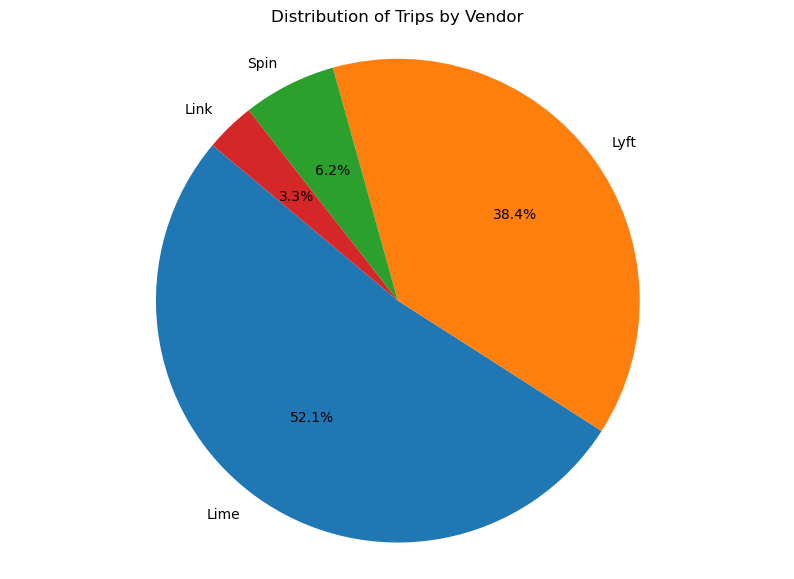

In [35]:
import matplotlib.pyplot as plt


# Generate the pie chart
plt.figure(figsize=(10, 7))  # Set the figure size for better readability
plt.pie(vendor_counts, labels=vendor_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Trips by Vendor')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

# Display the chart
plt.show()

### Vendor Distribution Analysis

In [42]:
# Calculate the percentage of trips by each vendor
vendor_distribution = df['Vendor'].value_counts(normalize = True) * 100
print(vendor_distribution)

Lime    52.053794
Lyft    38.388057
Spin     6.239641
Link     3.318508
Name: Vendor, dtype: float64


### Data Types & Quality Insights

In [43]:
# Overview of data types
print(df.dtypes)

# Descriptive statistics for numerical fields to spot any obvious issues
print(df.describe())

Trip ID                                object
Start Time                     datetime64[ns]
End Time                       datetime64[ns]
Trip Distance                           int64
Trip Duration                           int64
Vendor                                 object
Start Community Area Number           float64
End Community Area Number             float64
Start Community Area Name              object
End Community Area Name                object
Start Centroid Latitude               float64
Start Centroid Longitude              float64
Start Centroid Location                object
End Centroid Latitude                 float64
End Centroid Longitude                float64
End Centroid Location                  object
dtype: object
       Trip Distance  Trip Duration  Start Community Area Number  \
count   3.790619e+06   3.790619e+06                 3.790619e+06   
mean    2.355772e+03   8.410013e+02                 2.565720e+01   
std     1.021817e+04   1.092778e+03           

In [44]:
sample_rows = df.sample(n=5)
print(sample_rows)

                                      Trip ID          Start Time  \
2825053  198c8d45-a8f1-c9ca-198c-8d45a8f1c9ca 2023-08-01 22:00:00   
2902929  1991ac00-ff83-32c8-1991-ac00ff8332c8 2023-08-05 19:00:00   
3219635  13190589-8a81-48cf-bb33-73dcabdecb06 2023-08-24 19:00:00   
2514206  8eeba189-24e0-4095-bf4a-8bf04c906023 2023-07-11 12:00:00   
2649797  0b410b36-85ac-4273-b75a-c9b60c994b0b 2023-07-20 16:00:00   

                   End Time  Trip Distance  Trip Duration Vendor  \
2825053 2023-08-01 23:00:00           5581           3657   Lyft   
2902929 2023-08-05 20:00:00           4286           2213   Lyft   
3219635 2023-08-24 19:00:00           1600            703   Lime   
2514206 2023-07-11 12:00:00           1026            220   Lime   
2649797 2023-07-20 17:00:00           1569            587   Lime   

         Start Community Area Number  End Community Area Number  \
2825053                         33.0                       33.0   
2902929                         32.0      

In [46]:
# New dataset for EDA purposes
eda_data = df.loc[:, ['Start Time', 'Trip Distance', 'Trip Duration', 
                      'Start Community Area Name', 'End Community Area Name']].copy()

In [47]:
eda_data['Start Community Area Name'].value_counts()

Near North Side    479103
Near West Side     409137
Loop               353404
West Town          288476
Lincoln Park       265278
                    ...  
Forest Glen          1761
Burnside             1480
Edison Park          1035
Mount Greenwood       624
Ohare                 479
Name: Start Community Area Name, Length: 77, dtype: int64

77 communities

### Graph showing number of trips over time

In [48]:
# Count variable added
eda_data['count'] = 1

In [49]:
# Trips by date
trips_date_df = eda_data.groupby(pd.Grouper(key = 'Start Time', freq = 'D')).sum().reset_index()

In [50]:
trips_date_df.head()

,Start Time,Trip Distance,Trip Duration,count
0,2022-05-10,473259,187621,184
1,2022-05-11,938821,397005,446
2,2022-05-12,1429275,555921,632
3,2022-05-13,2001241,811006,853
4,2022-05-14,2212666,964947,880


In [51]:
# Calculate average
daily_average_trips = trips_date_df['count'].mean()
daily_average_trips

7447.188605108055

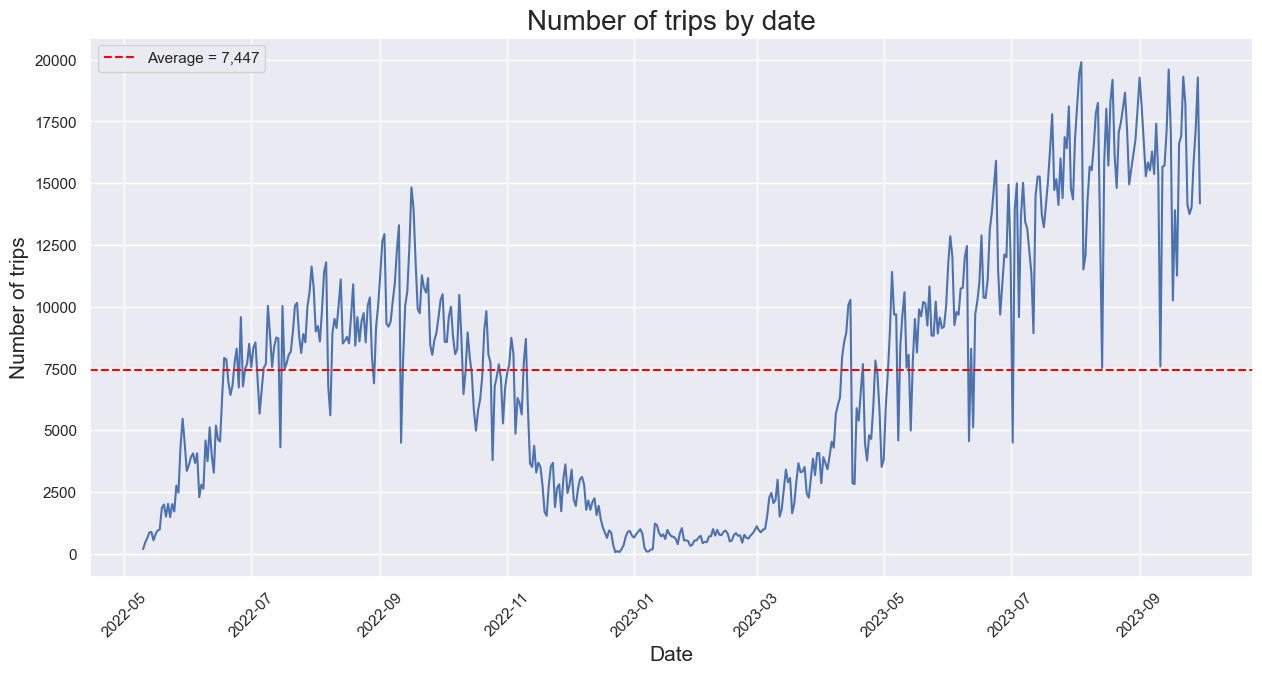

In [52]:
# Plot
plt.figure(figsize=(15, 7))
sns.set(style='darkgrid')

# Creating the lineplot
trips_date_df_plot = sns.lineplot(x = 'Start Time', y = 'count', data = trips_date_df)

# Insert average line from above
trips_date_df_plot.axhline(daily_average_trips, linestyle = "--", color = "red", label = "Average = 7,447") 

# Labels and title
plt.title('Number of trips by date', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Number of trips', fontsize = 15)
plt.xticks(rotation=45)

plt.legend()
plt.show()

## Distribution across the week

In [53]:
# Trips during each day in the week
trips_by_day = eda_data.copy()

In [54]:
# Adding a column with weekday names
trips_by_day['weekday'] = trips_by_day['Start Time'].dt.day_name()

In [55]:
# Convert weekday column from above to categorical
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
trips_by_day['weekday'] = pd.Categorical(trips_by_day['weekday'], categories = days, ordered = True)

In [56]:
# Summarizing trips by weekday name
trips_by_day = trips_by_day.groupby('weekday').sum().reset_index()

In [57]:
trips_by_day

,weekday,Trip Distance,Trip Duration,count
0,Monday,1083668423,386294006,465009
1,Tuesday,1189724994,403711070,515041
2,Wednesday,1221911369,417320659,540907
3,Thursday,1342472505,458615873,586129
4,Friday,1455869118,517042837,614902
5,Saturday,1439373291,550259619,591890
6,Sunday,1196815354,454671468,476741


In [58]:
# Calculate average
average_week = trips_by_day['count'].mean()
average_week

541517.0

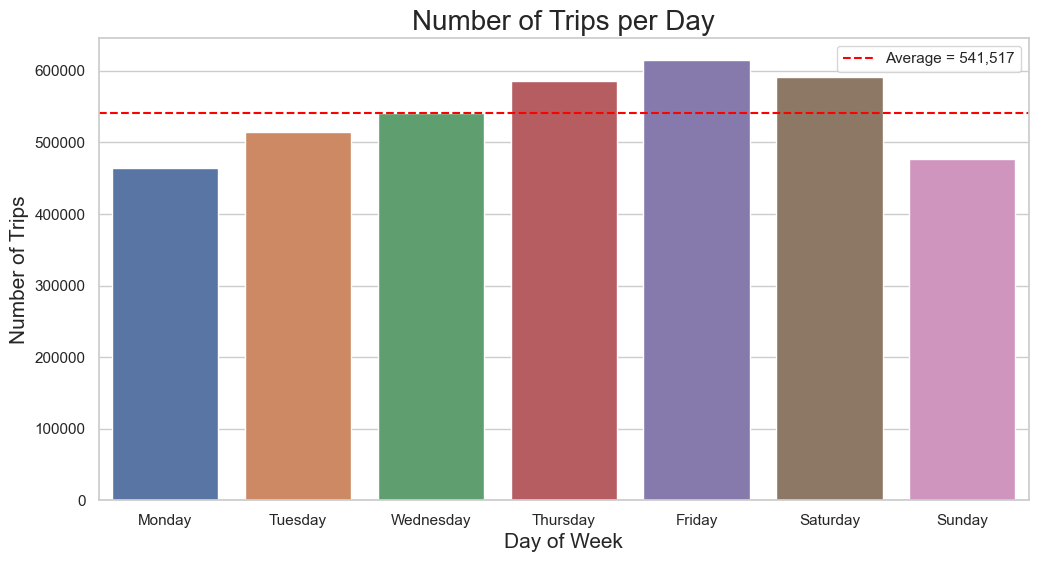

In [59]:
# Creating graph showing the number of electric scooter trips by weekday
plt.figure(figsize = (12, 6))
sns.set(style = 'whitegrid')

# Plot
trips_by_day_plot = sns.barplot(x = 'weekday', y = 'count', data = trips_by_day)


# Insert average line
trips_by_day_plot.axhline(average_week, linestyle = "--", color = "red", label = "Average = 541,517") 

plt.title('Number of Trips per Day', fontsize = 20)
plt.xlabel('Day of Week', fontsize = 15)
plt.ylabel('Number of Trips', fontsize = 15)

plt.legend()
plt.show()

## By hour

In [60]:
eda_data['hour_of_day'] = eda_data['Start Time'].dt.hour

In [61]:
eda_data_hour = eda_data.groupby('hour_of_day').sum().reset_index()
eda_data_hour.head()

,hour_of_day,Trip Distance,Trip Duration,count
0,0,132199475,47207907,52421
1,1,278601,123792,100
2,2,109407,70243,37
3,3,74786,35927,26
4,4,123865,58085,32


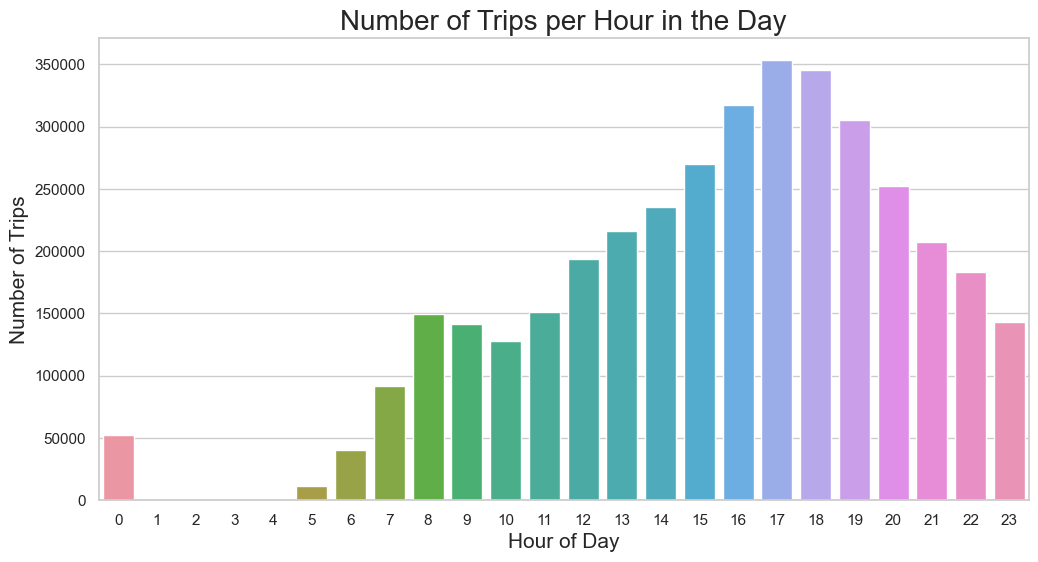

In [62]:
# Creating graph showing the number of electric scooter trips by hour in the day
plt.figure(figsize = (12, 6))
sns.set(style = 'whitegrid')

# Plot
eda_data_plot = sns.barplot(x = 'hour_of_day', y = 'count', data = eda_data_hour)

# Labels and titles
plt.title('Number of Trips per Hour in the Day', fontsize = 20)
plt.xlabel('Hour of Day', fontsize = 15)
plt.ylabel('Number of Trips', fontsize = 15)

plt.show()

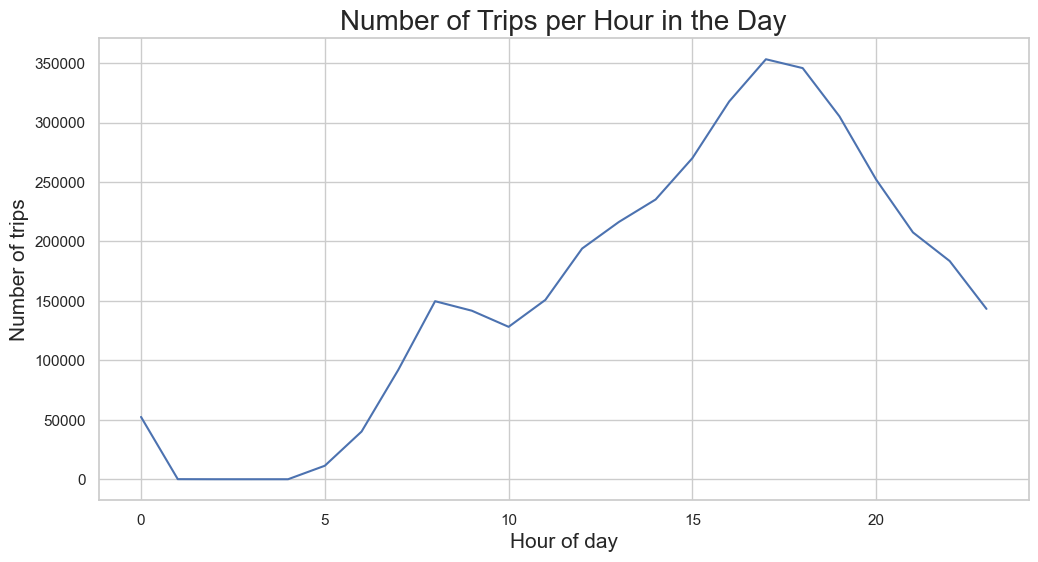

In [63]:
# Line plot
plt.figure(figsize = (12, 6))
sns.set(style = 'whitegrid')

graph1 = sns.lineplot(x = 'hour_of_day', y = 'count', data = eda_data_hour)

# Titles and labels
plt.title('Number of Trips per Hour in the Day', fontsize = 20)
plt.xlabel('Hour of day', fontsize = 15)
plt.ylabel('Number of trips', fontsize = 15)

plt.show()

### Partitioning Date Data

In [68]:
eda_data['hour_of_day'].value_counts()

17    353195
18    345751
16    317670
19    305192
15    270057
20    251952
14    235281
13    216382
21    207586
12    194035
22    183494
11    150841
8     149738
23    143285
9     141747
10    128197
7      92087
0      52421
6      40130
5      11383
1        100
2         37
4         32
3         26
Name: hour_of_day, dtype: int64

In [71]:
eda_data

,Start Time,Trip Distance,Trip Duration,Start Community Area Name,End Community Area Name,count,hour_of_day,Segment,type_of_rider
0,2022-05-28 14:00:00,2484,1544,Loop,Loop,1,14,Lunchtime Travelers,Lunchtime Travelers
1,2022-05-29 19:00:00,36,135,Loop,Loop,1,19,Afternoon Riders,Afternoon Riders
4,2022-06-10 00:00:00,2299,540,Near North Side,West Town,1,0,Late Night Riders,Late Night Riders
11,2022-06-20 18:00:00,3341,2383,Loop,Near North Side,1,18,Afternoon Riders,Afternoon Riders
15,2022-06-22 00:00:00,25,148,Loop,Loop,1,0,Late Night Riders,Late Night Riders
...,...,...,...,...,...,...,...,...,...
3797232,2023-09-30 17:00:00,1794,1113,Dunning,Belmont Cragin,1,17,Afternoon Riders,Afternoon Riders
3797233,2023-09-30 18:00:00,1040,324,Near North Side,Near North Side,1,18,Afternoon Riders,Afternoon Riders
3797234,2023-09-30 19:00:00,7235,5507,Greater Grand Crossing,Greater Grand Crossing,1,19,Afternoon Riders,Afternoon Riders
3797235,2023-09-30 16:00:00,2908,1966,Auburn Gresham,Auburn Gresham,1,16,Afternoon Riders,Afternoon Riders


In [101]:
from itertools import chain

# Dictionary for time segments
time_segments = {
    'Morning Commutes': range(5, 11),  # 5 AM to 10 AM
    'Lunchtime Travelers': range(11, 16),  # 10 AM to 3 PM
    'Afternoon Riders': range(16, 21),  # 3 PM to 8 PM
    'Late Night Riders': list(chain(range(21, 24), range(0, 1)))  # 8 PM to Midnight to 1 AM
}

# Lambda function to segment the times
eda_data['type_of_rider'] = eda_data['hour_of_day'].apply(lambda x: next((segment for segment, hours in time_segments.items() if x in hours), None))

# Group by segment and sum the counts
segmented_data = eda_data.groupby('type_of_rider')['count'].sum().reset_index()
sorted_segmented_data = segmented_data.sort_values(by = 'count')
sorted_segmented_data

,type_of_rider,count
3,Morning Commutes,435085
1,Late Night Riders,838738
2,Lunchtime Travelers,1194793
0,Afternoon Riders,1321808


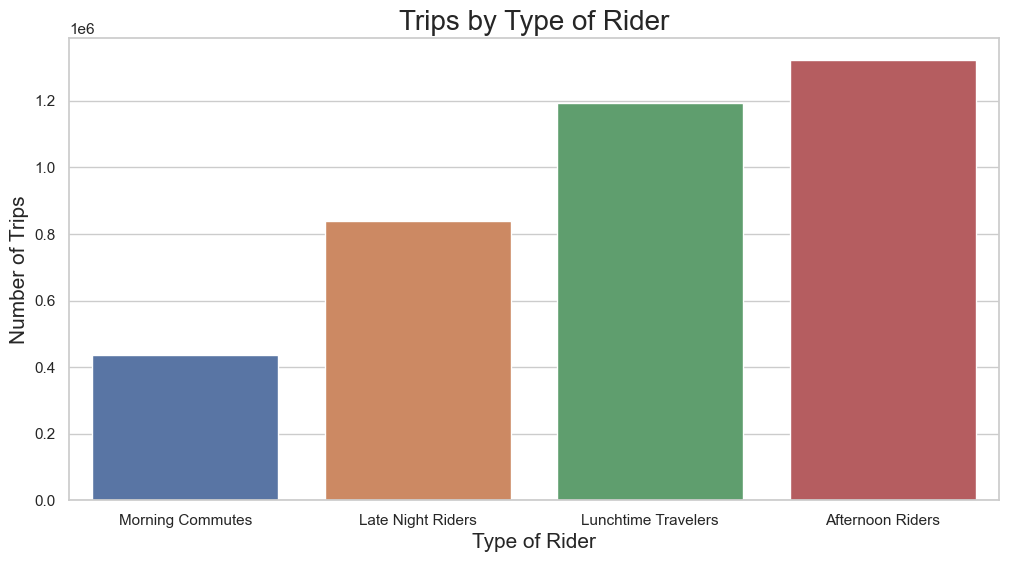

In [102]:
# Creating graph showing the number of electric scooter trips by hour in the day
plt.figure(figsize = (12, 6))
sns.set(style = 'whitegrid')

# Plot
eda_data_plot = sns.barplot(x = 'type_of_rider', y = 'count', data = sorted_segmented_data)

# Labels and titles
plt.title('Trips by Type of Rider', fontsize = 20)
plt.xlabel('Type of Rider', fontsize = 15)
plt.ylabel('Number of Trips', fontsize = 15)

plt.show()

### Add is_weekend variable

In [113]:
# Adding is_weekend variable
eda_data['weekday'] = eda_data['Start Time'].dt.day_name()
eda_data['is_weekend'] = eda_data['weekday'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

In [114]:
eda_data

,Start Time,Trip Distance,Trip Duration,Start Community Area Name,End Community Area Name,count,hour_of_day,Segment,type_of_rider,weekday,is_weekend
0,2022-05-28 14:00:00,2484,1544,Loop,Loop,1,14,Lunchtime Travelers,Lunchtime Travelers,Saturday,1
1,2022-05-29 19:00:00,36,135,Loop,Loop,1,19,Afternoon Riders,Afternoon Riders,Sunday,1
4,2022-06-10 00:00:00,2299,540,Near North Side,West Town,1,0,Late Night Riders,Late Night Riders,Friday,0
11,2022-06-20 18:00:00,3341,2383,Loop,Near North Side,1,18,Afternoon Riders,Afternoon Riders,Monday,0
15,2022-06-22 00:00:00,25,148,Loop,Loop,1,0,Late Night Riders,Late Night Riders,Wednesday,0
...,...,...,...,...,...,...,...,...,...,...,...
3797232,2023-09-30 17:00:00,1794,1113,Dunning,Belmont Cragin,1,17,Afternoon Riders,Afternoon Riders,Saturday,1
3797233,2023-09-30 18:00:00,1040,324,Near North Side,Near North Side,1,18,Afternoon Riders,Afternoon Riders,Saturday,1
3797234,2023-09-30 19:00:00,7235,5507,Greater Grand Crossing,Greater Grand Crossing,1,19,Afternoon Riders,Afternoon Riders,Saturday,1
3797235,2023-09-30 16:00:00,2908,1966,Auburn Gresham,Auburn Gresham,1,16,Afternoon Riders,Afternoon Riders,Saturday,1


In [120]:
weekend_percentages = eda_data['is_weekend'].value_counts(normalize = True) * 100
weekend_percentages

0    71.808536
1    28.191464
Name: is_weekend, dtype: float64

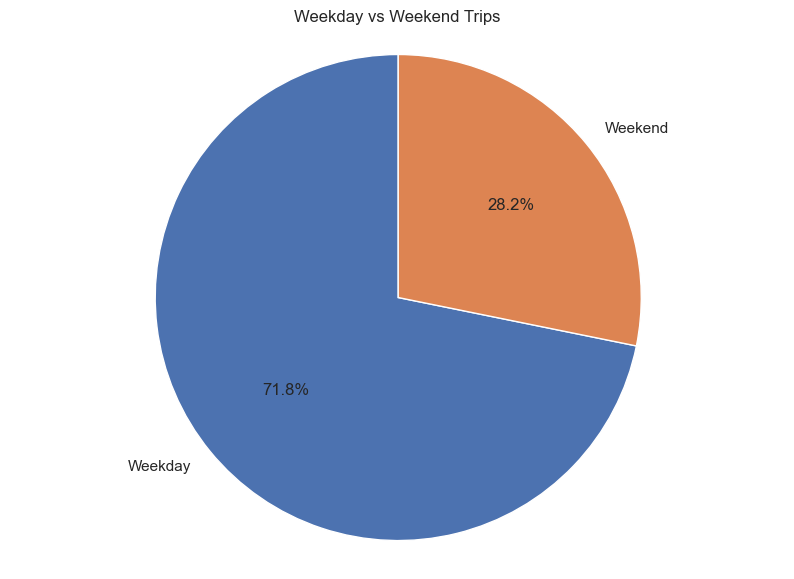

In [124]:
# Generate the pie chart
plt.figure(figsize = (10, 7))  # Set the figure size for better readability
plt.pie(weekend_percentages, labels = ['Weekday', 'Weekend'], autopct = '%1.1f%%', startangle = 90)
plt.title('Weekday vs Weekend Trips')
plt.axis('equal')

# Display the chart
plt.show()